In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 9295
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #pole length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  VBKG0BIX_03_14_58
NN-MODEL FILENAME:  ./models/VBKG0BIX_03_14_58_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.925
LENGTH_ABS_MIN = 0.375

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 1
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  1


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
     # Mean values of pole length deviate from original value
    scaling_factor = 0.8 + (1.8 - 0.8) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    LENGTH_MAX = length_mean + 0.025
    LENGTH_MIN = length_mean - 0.025

    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN,     LENGTH_MAX,     LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    my_Q_TABLE = node_q_table[:,:,:,:, int(node_id*LO_GRAIN):int((node_id+1)*LO_GRAIN)]

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN*NO_OF_NODES   ])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN,LO_GRAIN*NO_OF_NODES).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 11902.62 MiB, increment: 10783.79 MiB
Quantization TIME:  0.1 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   39753
SMALLEST TIMESTEP: 9
LARGEST  TIMESTEP: 146
TOTAL SERIAL TIMESTEPS:   39753
TOTAL PARALLEL TIMESTEPS: 146


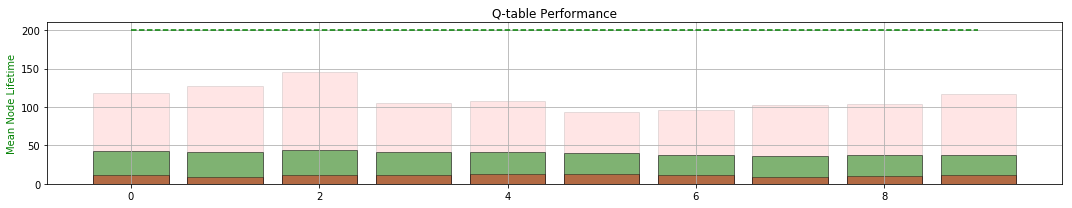

MEMORY COUNTER:  39753
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 249.888	LOSS : 232.241	LOSS : 247.337	LOSS : 232.579	LOSS : 256.784	LOSS : 222.365	LOSS : 262.561	LOSS : 240.414	LOSS : 217.006	LOSS : 226.589	LOSS : 225.031	LOSS : 211.071	LOSS : 223.142	LOSS : 226.548	LOSS : 229.906	LOSS : 222.847	LOSS : 223.203	LOSS : 227.922	LOSS : 224.612	LOSS : 213.895	
Validating... MEAN TIME:  200.0
LOSS : 207.411	LOSS : 223.421	LOSS : 214.930	LOSS : 214.860	LOSS : 203.245	LOSS : 219.358	LOSS : 211.389	LOSS : 200.934	LOSS : 209.411	LOSS : 219.459	LOSS : 220.360	LOSS : 204.959	LOSS : 218.258	LOSS : 213.372	LOSS : 212.629	LOSS : 214.668	LOSS : 222.073	LOSS : 216.450	LOSS : 212.229	LOSS : 210.225	
Validating... MEAN TIME:  177.73
LOSS : 223.627	LOSS : 201.833	LOSS : 209.174	LOSS : 214.263	LOSS : 213.485	LOSS : 208.255	LOSS : 204.930	LOSS : 215.767	LOSS : 212.643	LOSS : 200.491	LOSS : 211.092	LOSS : 201.782	LOSS : 211.965	LOSS : 208.843	LOSS : 195.384	LOSS : 205.403	LOSS : 204.

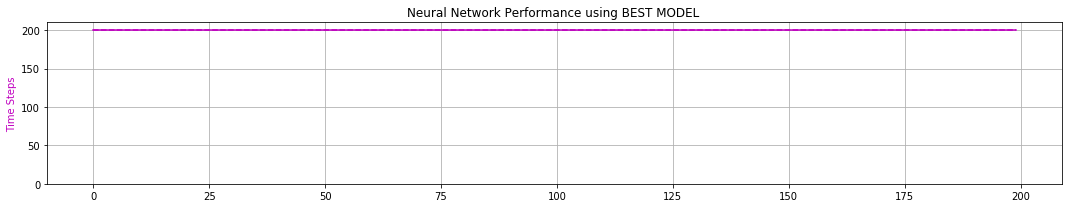

peak memory: 12035.53 MiB, increment: 10679.21 MiB
0 -max- [ 1.008  1.921  0.209  1.917  0.475]
0 -min- [-0.681 -2.080 -0.209 -1.977  0.425]

1 -max- [ 1.970  2.847  0.208  2.127  0.525]
1 -min- [-0.881 -1.496 -0.209 -2.175  0.476]

2 -max- [ 0.884  1.881  0.209  1.622  0.575]
2 -min- [-0.444 -1.321 -0.209 -2.127  0.526]

3 -max- [ 1.181  2.284  0.209  1.700  0.624]
3 -min- [-0.588 -1.195 -0.209 -2.060  0.575]

4 -max- [ 1.132  2.416  0.209  1.709  0.675]
4 -min- [-0.552 -1.190 -0.209 -2.249  0.626]

5 -max- [ 1.207  2.124  0.207  1.574  0.725]
5 -min- [-0.304 -1.027 -0.209 -2.051  0.676]

6 -max- [ 0.861  1.738  0.207  1.940  0.775]
6 -min- [-0.609 -1.165 -0.209 -2.322  0.725]

7 -max- [ 1.438  2.194  0.209  2.190  0.825]
7 -min- [-0.534 -1.201 -0.209 -2.478  0.776]

8 -max- [ 1.014  1.478  0.209  1.746  0.875]
8 -min- [-0.236 -1.188 -0.209 -2.166  0.825]

9 -max- [ 1.085  2.425  0.204  2.093  0.925]
9 -min- [-0.185 -1.406 -0.209 -2.141  0.875]

Quantization TIME:  0.1 minutes


ITERA

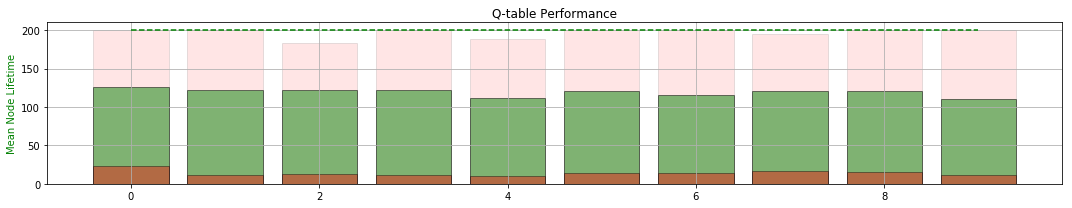

MEMORY COUNTER:  158882
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 140.914	LOSS : 133.718	LOSS : 120.911	LOSS : 106.866	LOSS : 120.176	LOSS : 106.016	LOSS : 108.523	LOSS : 109.921	LOSS : 114.881	LOSS : 122.601	LOSS : 113.863	LOSS : 112.117	LOSS : 116.240	LOSS : 108.864	LOSS : 115.297	LOSS : 104.805	LOSS : 123.742	LOSS : 99.591	LOSS : 104.625	LOSS : 115.883	
Validating... MEAN TIME:  143.32
LOSS : 126.543	LOSS : 119.134	LOSS : 110.089	LOSS : 108.033	LOSS : 113.713	LOSS : 121.482	LOSS : 107.086	LOSS : 122.915	LOSS : 105.167	LOSS : 117.032	LOSS : 96.980	LOSS : 120.942	LOSS : 118.563	LOSS : 103.305	LOSS : 97.966	LOSS : 103.641	LOSS : 107.617	LOSS : 114.862	LOSS : 108.746	LOSS : 98.121	
Validating... MEAN TIME:  131.445
LOSS : 109.917	LOSS : 120.414	LOSS : 117.882	LOSS : 125.267	LOSS : 111.805	LOSS : 103.004	LOSS : 114.792	LOSS : 104.183	LOSS : 113.621	LOSS : 113.324	LOSS : 109.350	LOSS : 110.324	LOSS : 111.276	LOSS : 119.909	LOSS : 117.356	LOSS : 111.556	LOSS : 109.9

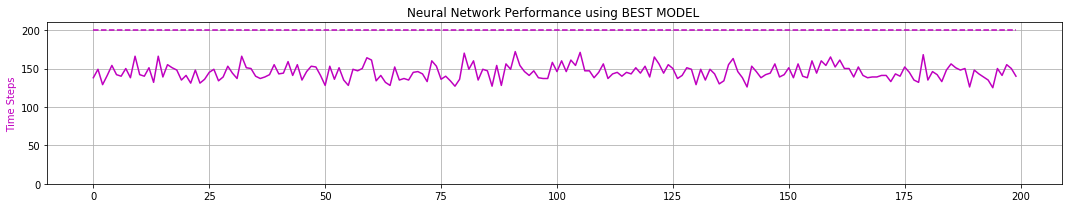

peak memory: 12263.15 MiB, increment: 10674.50 MiB
0 -max- [ 0.388  1.487  0.209  1.886  0.474]
0 -min- [-2.400 -2.629 -0.209 -2.018  0.425]

1 -max- [ 0.207  1.007  0.208  1.695  0.525]
1 -min- [-2.399 -2.632 -0.209 -1.833  0.475]

2 -max- [ 0.221  1.158  0.197  1.749  0.575]
2 -min- [-2.400 -2.820 -0.209 -1.943  0.525]

3 -max- [ 0.310  1.717  0.208  2.184  0.624]
3 -min- [-2.400 -2.982 -0.209 -1.955  0.576]

4 -max- [ 0.225  1.341  0.207  2.195  0.674]
4 -min- [-2.398 -2.813 -0.209 -2.182  0.625]

5 -max- [ 0.376  1.183  0.207  2.019  0.724]
5 -min- [-2.400 -2.595 -0.209 -2.064  0.675]

6 -max- [ 0.239  1.161  0.206  1.662  0.774]
6 -min- [-2.400 -2.669 -0.209 -2.008  0.725]

7 -max- [ 0.278  1.222  0.205  1.814  0.824]
7 -min- [-2.395 -3.101 -0.209 -2.087  0.776]

8 -max- [ 0.433  1.313  0.201  2.054  0.875]
8 -min- [-2.398 -3.352 -0.209 -2.227  0.827]

9 -max- [ 0.301  1.568  0.209  1.919  0.925]
9 -min- [-2.399 -2.643 -0.209 -2.283  0.875]

Quantization TIME:  0.1 minutes


ITERA

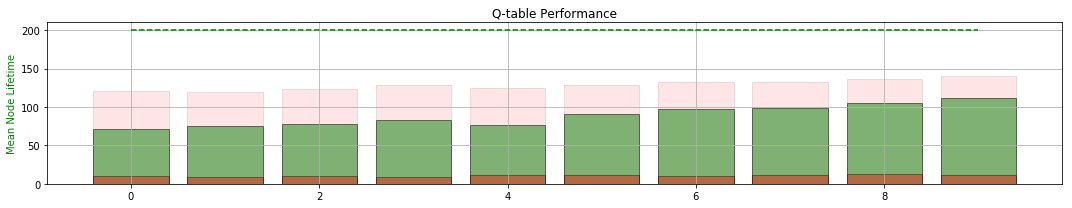

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 107.113	LOSS : 105.637	LOSS : 103.009	LOSS : 101.686	LOSS : 96.675	LOSS : 91.588	LOSS : 94.873	LOSS : 91.487	LOSS : 109.279	LOSS : 102.036	LOSS : 102.305	LOSS : 94.648	LOSS : 96.542	LOSS : 91.760	LOSS : 99.534	LOSS : 88.621	LOSS : 94.288	LOSS : 83.649	LOSS : 92.134	LOSS : 96.969	
Validating... MEAN TIME:  136.925
LOSS : 88.884	LOSS : 79.913	LOSS : 87.039	LOSS : 105.843	LOSS : 89.357	LOSS : 91.149	LOSS : 93.233	LOSS : 92.464	LOSS : 87.155	LOSS : 92.421	LOSS : 101.676	LOSS : 85.187	LOSS : 96.362	LOSS : 85.439	LOSS : 75.646	LOSS : 98.439	LOSS : 113.011	LOSS : 78.802	LOSS : 93.858	LOSS : 99.168	
Validating... MEAN TIME:  137.915
LOSS : 85.361	LOSS : 87.965	LOSS : 86.578	LOSS : 87.933	LOSS : 95.660	LOSS : 94.188	LOSS : 96.481	LOSS : 82.727	LOSS : 94.588	LOSS : 82.563	LOSS : 95.265	LOSS : 84.987	LOSS : 95.776	LOSS : 86.557	LOSS : 86.859	LOSS : 98.582	LOSS : 97.755	LOSS : 86.333	LOSS : 86.800	LOSS : 87.2

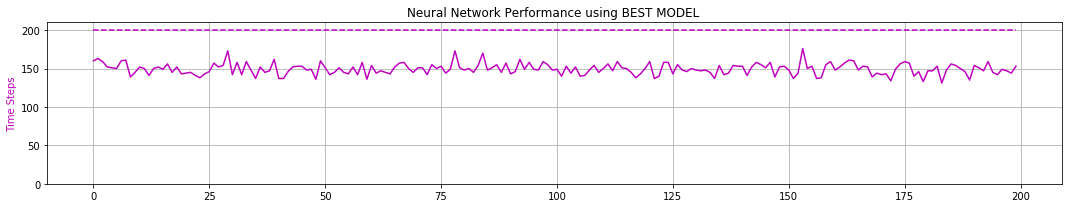

peak memory: 12294.71 MiB, increment: 10690.96 MiB
0 -max- [ 0.206  1.217  0.048  1.094  0.475]
0 -min- [-2.399 -2.826 -0.209 -1.787  0.425]

1 -max- [ 0.200  1.179  0.050  1.376  0.524]
1 -min- [-2.399 -2.817 -0.209 -1.722  0.476]

2 -max- [ 0.201  1.210  0.047  1.430  0.575]
2 -min- [-2.400 -2.798 -0.209 -1.806  0.526]

3 -max- [ 0.227  1.524  0.055  1.195  0.620]
3 -min- [-2.400 -2.767 -0.209 -2.292  0.575]

4 -max- [ 0.286  1.566  0.123  1.402  0.674]
4 -min- [-2.400 -2.800 -0.209 -2.083  0.626]

5 -max- [ 0.206  1.357  0.205  1.698  0.724]
5 -min- [-2.400 -2.928 -0.209 -2.043  0.676]

6 -max- [ 0.173  1.368  0.048  1.209  0.775]
6 -min- [-2.399 -2.936 -0.209 -1.976  0.725]

7 -max- [ 0.211  1.180  0.053  1.406  0.825]
7 -min- [-2.400 -2.776 -0.209 -1.666  0.776]

8 -max- [ 0.200  1.183  0.106  1.223  0.872]
8 -min- [-2.400 -2.640 -0.209 -1.714  0.825]

9 -max- [ 0.191  1.129  0.063  1.457  0.924]
9 -min- [-2.400 -2.631 -0.209 -1.654  0.875]

Quantization TIME:  0.1 minutes


ITERA

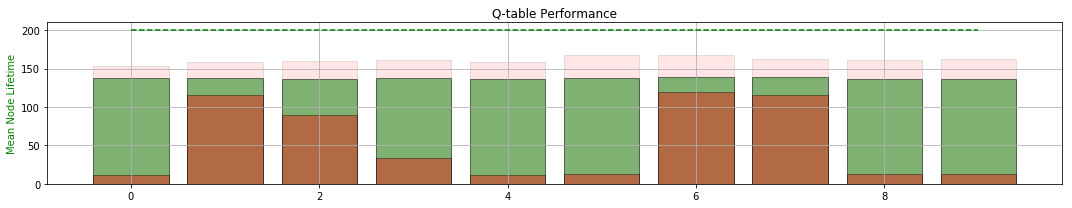

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 91.859	LOSS : 84.916	LOSS : 81.881	LOSS : 80.506	LOSS : 80.022	LOSS : 80.960	LOSS : 89.807	LOSS : 89.318	LOSS : 85.026	LOSS : 78.084	LOSS : 83.850	LOSS : 80.134	LOSS : 79.581	LOSS : 79.292	LOSS : 86.377	LOSS : 79.949	LOSS : 81.127	LOSS : 81.843	LOSS : 82.602	LOSS : 89.716	
Validating... MEAN TIME:  125.33
LOSS : 78.941	LOSS : 81.108	LOSS : 74.529	LOSS : 79.888	LOSS : 93.123	LOSS : 74.200	LOSS : 80.341	LOSS : 83.547	LOSS : 82.691	LOSS : 81.200	LOSS : 86.253	LOSS : 73.651	LOSS : 83.559	LOSS : 83.256	LOSS : 75.632	LOSS : 80.032	LOSS : 79.939	LOSS : 90.485	LOSS : 71.615	LOSS : 93.296	
Validating... MEAN TIME:  141.26
LOSS : 77.890	LOSS : 80.344	LOSS : 78.613	LOSS : 79.815	LOSS : 78.564	LOSS : 73.260	LOSS : 76.326	LOSS : 84.383	LOSS : 85.216	LOSS : 72.614	LOSS : 84.904	LOSS : 80.312	LOSS : 73.136	LOSS : 82.358	LOSS : 74.681	LOSS : 80.446	LOSS : 82.844	LOSS : 75.068	LOSS : 77.371	LOSS : 69.171	
Validati

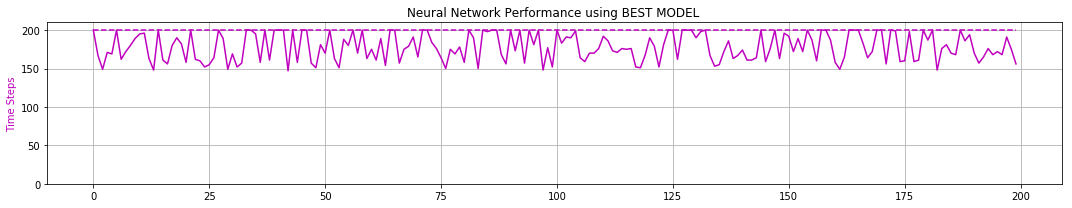

peak memory: 12314.00 MiB, increment: 10670.09 MiB
0 -max- [ 0.169  1.179  0.051  1.599  0.475]
0 -min- [-2.400 -2.530 -0.204 -1.671  0.427]

1 -max- [ 0.178  1.167  0.047  1.477  0.525]
1 -min- [-2.400 -2.609 -0.186 -1.677  0.475]

2 -max- [ 0.191  1.205  0.048  1.469  0.575]
2 -min- [-2.399 -2.423 -0.195 -1.677  0.525]

3 -max- [ 0.165  1.150  0.048  1.602  0.625]
3 -min- [-2.400 -2.752 -0.204 -1.718  0.575]

4 -max- [ 0.185  1.206  0.092  1.891  0.675]
4 -min- [-2.400 -2.417 -0.206 -1.774  0.627]

5 -max- [ 0.185  1.209  0.061  1.558  0.725]
5 -min- [-2.399 -2.405 -0.207 -1.763  0.677]

6 -max- [ 0.174  1.205  0.058  1.555  0.775]
6 -min- [-2.400 -2.442 -0.207 -1.679  0.725]

7 -max- [ 0.171  1.161  0.060  1.596  0.825]
7 -min- [-2.400 -2.425 -0.204 -1.673  0.775]

8 -max- [ 0.190  1.217  0.069  1.641  0.874]
8 -min- [-2.400 -2.416 -0.209 -1.747  0.825]

9 -max- [ 0.181  1.215  0.085  1.648  0.925]
9 -min- [-2.399 -2.456 -0.209 -1.735  0.876]

Quantization TIME:  0.1 minutes


ITERA

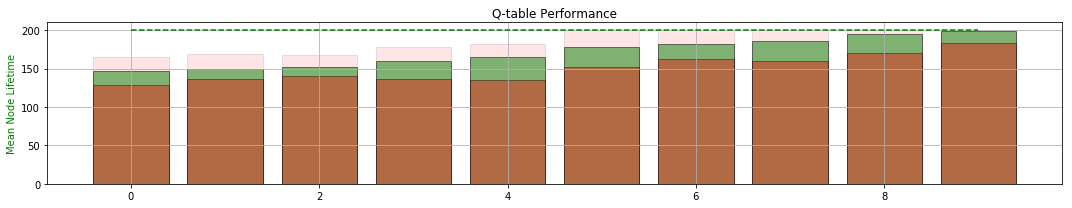

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 56.960	LOSS : 58.816	LOSS : 52.272	LOSS : 56.068	LOSS : 58.136	LOSS : 51.132	LOSS : 57.973	LOSS : 40.988	LOSS : 52.968	LOSS : 43.065	LOSS : 58.407	LOSS : 62.094	LOSS : 52.408	LOSS : 50.061	LOSS : 50.887	LOSS : 41.132	LOSS : 50.474	LOSS : 45.612	LOSS : 52.276	LOSS : 48.849	
Validating... MEAN TIME:  124.435
LOSS : 47.846	LOSS : 50.515	LOSS : 52.749	LOSS : 54.781	LOSS : 57.088	LOSS : 56.991	LOSS : 50.718	LOSS : 49.601	LOSS : 51.287	LOSS : 53.827	LOSS : 42.130	LOSS : 52.772	LOSS : 54.575	LOSS : 52.113	LOSS : 57.612	LOSS : 49.208	LOSS : 52.018	LOSS : 56.688	LOSS : 47.891	LOSS : 60.942	
Validating... MEAN TIME:  182.79
LOSS : 51.518	LOSS : 52.738	LOSS : 53.644	LOSS : 47.552	LOSS : 51.689	LOSS : 50.752	LOSS : 54.268	LOSS : 57.677	LOSS : 50.704	LOSS : 55.003	LOSS : 43.194	LOSS : 50.567	LOSS : 53.747	LOSS : 47.148	LOSS : 52.578	LOSS : 51.860	LOSS : 52.083	LOSS : 47.111	LOSS : 54.964	LOSS : 50.823	
Validat

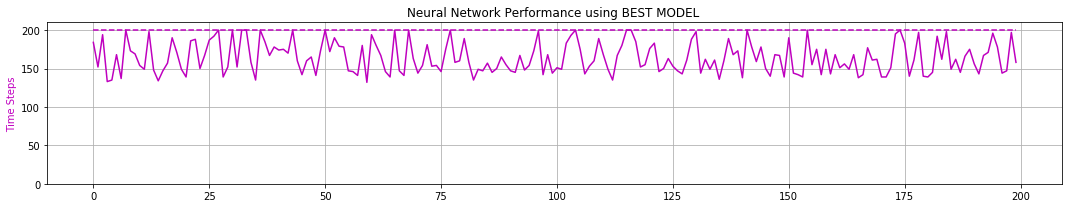

peak memory: 12349.39 MiB, increment: 10693.54 MiB
0 -max- [ 0.121  0.947  0.047  0.915  0.475]
0 -min- [-2.400 -2.779 -0.205 -1.445  0.425]

1 -max- [ 0.163  1.009  0.048  0.919  0.523]
1 -min- [-2.400 -2.539 -0.177 -1.392  0.475]

2 -max- [ 0.128  0.828  0.048  0.958  0.575]
2 -min- [-2.400 -2.582 -0.208 -1.175  0.525]

3 -max- [ 0.115  0.826  0.046  1.136  0.625]
3 -min- [-2.400 -2.603 -0.201 -1.281  0.576]

4 -max- [ 0.110  0.820  0.048  0.862  0.675]
4 -min- [-2.400 -2.614 -0.203 -1.265  0.625]

5 -max- [ 0.112  0.825  0.053  0.989  0.724]
5 -min- [-2.400 -2.622 -0.207 -1.172  0.676]

6 -max- [ 0.107  0.824  0.049  1.045  0.775]
6 -min- [-2.400 -2.448 -0.205 -1.233  0.725]

7 -max- [ 0.126  0.810  0.049  1.015  0.825]
7 -min- [-2.398 -2.440 -0.209 -1.175  0.775]

8 -max- [ 0.127  0.825  0.053  0.993  0.875]
8 -min- [-2.399 -2.428 -0.208 -1.327  0.825]

9 -max- [ 0.134  0.824  0.048  0.802  0.923]
9 -min- [-2.397 -2.259 -0.207 -1.089  0.876]

Quantization TIME:  0.1 minutes


ITERA

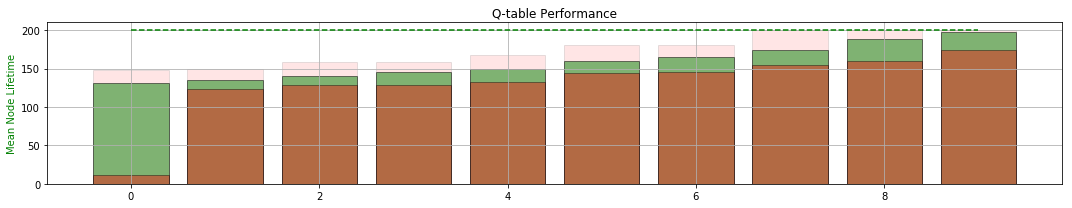

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 56.696	LOSS : 52.274	LOSS : 48.065	LOSS : 55.808	LOSS : 56.064	LOSS : 55.580	LOSS : 59.958	LOSS : 50.833	LOSS : 47.811	LOSS : 50.745	LOSS : 60.704	LOSS : 61.105	LOSS : 51.404	LOSS : 61.299	LOSS : 56.003	LOSS : 52.286	LOSS : 57.792	LOSS : 50.636	LOSS : 57.436	LOSS : 58.941	
Validating... MEAN TIME:  98.77
LOSS : 55.493	LOSS : 47.334	LOSS : 58.451	LOSS : 54.070	LOSS : 50.939	LOSS : 55.436	LOSS : 52.993	LOSS : 52.849	LOSS : 50.020	LOSS : 49.750	LOSS : 53.626	LOSS : 55.411	LOSS : 57.414	LOSS : 47.691	LOSS : 54.906	LOSS : 53.832	LOSS : 56.987	LOSS : 60.704	LOSS : 49.641	LOSS : 52.386	
Validating... MEAN TIME:  129.505
LOSS : 53.915	LOSS : 55.177	LOSS : 50.074	LOSS : 56.529	LOSS : 51.756	LOSS : 54.760	LOSS : 50.971	LOSS : 54.691	LOSS : 58.142	LOSS : 55.869	LOSS : 49.045	LOSS : 50.407	LOSS : 58.701	LOSS : 49.468	LOSS : 59.162	LOSS : 46.382	LOSS : 50.610	LOSS : 53.400	LOSS : 52.382	LOSS : 49.899	
Validati

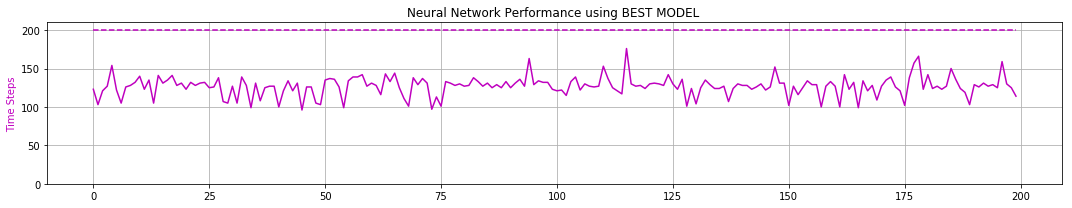

peak memory: 12354.63 MiB, increment: 10696.88 MiB
0 -max- [ 0.208  1.396  0.048  1.630  0.474]
0 -min- [-2.399 -2.989 -0.206 -1.952  0.425]

1 -max- [ 0.156  1.132  0.048  1.516  0.525]
1 -min- [-2.399 -2.902 -0.208 -1.710  0.475]

2 -max- [ 0.147  1.021  0.046  1.317  0.574]
2 -min- [-2.399 -2.809 -0.209 -1.470  0.525]

3 -max- [ 0.141  1.018  0.048  1.475  0.625]
3 -min- [-2.399 -2.777 -0.208 -1.476  0.575]

4 -max- [ 0.156  1.020  0.049  1.388  0.675]
4 -min- [-2.399 -2.945 -0.208 -1.517  0.626]

5 -max- [ 0.135  1.009  0.049  1.415  0.723]
5 -min- [-2.400 -2.622 -0.207 -1.486  0.675]

6 -max- [ 0.181  1.156  0.056  1.504  0.774]
6 -min- [-2.399 -2.584 -0.202 -1.670  0.725]

7 -max- [ 0.141  0.966  0.071  1.387  0.825]
7 -min- [-2.399 -2.535 -0.199 -1.477  0.776]

8 -max- [ 0.152  1.019  0.048  1.153  0.875]
8 -min- [-2.400 -2.587 -0.208 -1.564  0.826]

9 -max- [ 0.124  0.964  0.057  1.433  0.924]
9 -min- [-2.399 -2.256 -0.209 -1.412  0.875]

Quantization TIME:  0.1 minutes


ITERA

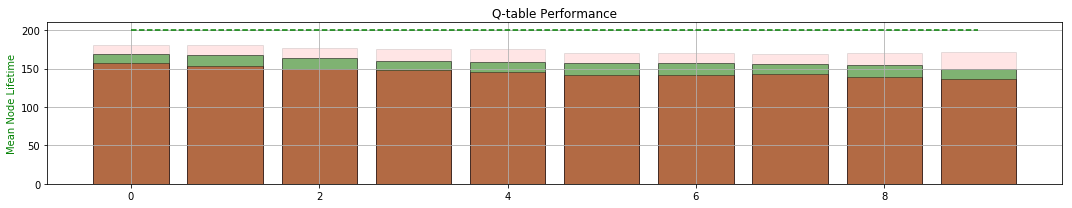

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 74.020	LOSS : 95.928	LOSS : 87.188	LOSS : 75.848	LOSS : 76.205	LOSS : 69.762	LOSS : 69.509	LOSS : 73.423	LOSS : 69.094	LOSS : 77.075	LOSS : 66.674	LOSS : 75.576	LOSS : 62.172	LOSS : 75.093	LOSS : 59.349	LOSS : 68.799	LOSS : 68.332	LOSS : 65.242	LOSS : 67.433	LOSS : 70.073	
Validating... MEAN TIME:  138.705
LOSS : 67.225	LOSS : 66.097	LOSS : 70.351	LOSS : 58.269	LOSS : 72.910	LOSS : 65.081	LOSS : 68.327	LOSS : 68.071	LOSS : 56.460	LOSS : 62.609	LOSS : 62.951	LOSS : 58.908	LOSS : 57.355	LOSS : 62.477	LOSS : 59.127	LOSS : 52.384	LOSS : 66.171	LOSS : 59.101	LOSS : 59.623	LOSS : 63.230	
Validating... MEAN TIME:  10.555
LOSS : 55.426	LOSS : 55.422	LOSS : 55.010	LOSS : 60.817	LOSS : 56.275	LOSS : 57.436	LOSS : 58.331	LOSS : 49.675	LOSS : 59.753	LOSS : 59.297	LOSS : 63.716	LOSS : 67.673	LOSS : 53.100	LOSS : 57.061	LOSS : 61.072	LOSS : 51.627	LOSS : 64.302	LOSS : 57.900	LOSS : 63.205	LOSS : 56.706	
Validat

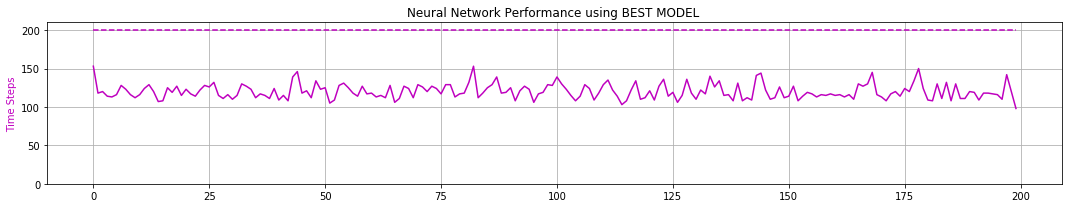

peak memory: 12357.56 MiB, increment: 10684.00 MiB
0 -max- [ 2.400  2.006  0.209  1.141  0.475]
0 -min- [-0.140 -0.758 -0.048 -0.983  0.425]

1 -max- [ 2.400  1.968  0.208  1.361  0.525]
1 -min- [-0.161 -0.939 -0.050 -0.972  0.478]

2 -max- [ 2.400  1.975  0.193  1.364  0.575]
2 -min- [-0.165 -0.933 -0.050 -0.801  0.525]

3 -max- [ 2.400  2.014  0.200  1.251  0.623]
3 -min- [-0.149 -0.823 -0.048 -0.986  0.575]

4 -max- [ 2.400  2.053  0.209  1.251  0.674]
4 -min- [-0.158 -0.832 -0.048 -0.928  0.625]

5 -max- [ 2.400  1.975  0.200  1.169  0.724]
5 -min- [-0.171 -0.826 -0.047 -0.974  0.675]

6 -max- [ 2.400  2.070  0.192  1.439  0.775]
6 -min- [-0.171 -0.973 -0.049 -0.954  0.726]

7 -max- [ 2.400  2.073  0.208  1.364  0.825]
7 -min- [-0.148 -0.965 -0.049 -1.000  0.777]

8 -max- [ 2.399  1.984  0.193  1.214  0.875]
8 -min- [-0.185 -0.796 -0.063 -1.172  0.825]

9 -max- [ 2.399  1.878  0.207  1.180  0.923]
9 -min- [-0.157 -0.769 -0.047 -0.821  0.875]

Quantization TIME:  0.1 minutes


ITERA

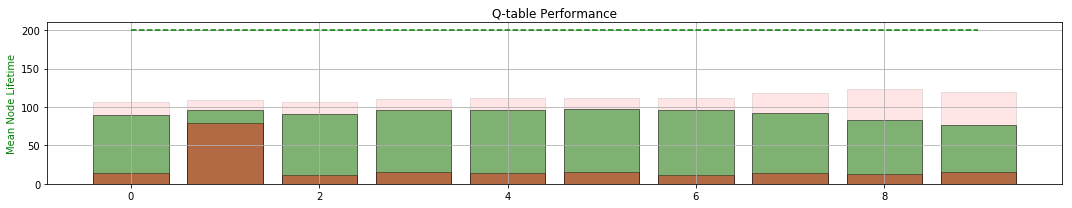

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 69.948	LOSS : 81.129	LOSS : 77.782	LOSS : 74.871	LOSS : 81.836	LOSS : 92.134	LOSS : 87.026	LOSS : 79.973	LOSS : 76.282	LOSS : 94.766	LOSS : 85.197	LOSS : 84.909	LOSS : 89.178	LOSS : 93.052	LOSS : 88.440	LOSS : 85.856	LOSS : 82.685	LOSS : 76.463	LOSS : 84.106	LOSS : 86.574	
Validating... MEAN TIME:  116.305
LOSS : 76.198	LOSS : 81.298	LOSS : 81.537	LOSS : 81.637	LOSS : 75.292	LOSS : 84.743	LOSS : 85.580	LOSS : 83.689	LOSS : 73.559	LOSS : 83.408	LOSS : 76.851	LOSS : 80.215	LOSS : 83.836	LOSS : 79.221	LOSS : 70.166	LOSS : 84.239	LOSS : 81.068	LOSS : 83.258	LOSS : 77.862	LOSS : 79.297	
Validating... MEAN TIME:  199.42
LOSS : 80.890	LOSS : 84.698	LOSS : 81.576	LOSS : 85.380	LOSS : 84.708	LOSS : 78.422	LOSS : 80.631	LOSS : 78.902	LOSS : 80.404	LOSS : 82.218	LOSS : 89.870	LOSS : 89.755	LOSS : 75.666	LOSS : 72.786	LOSS : 83.384	LOSS : 75.792	LOSS : 85.808	LOSS : 76.335	LOSS : 79.688	LOSS : 74.142	
Validat

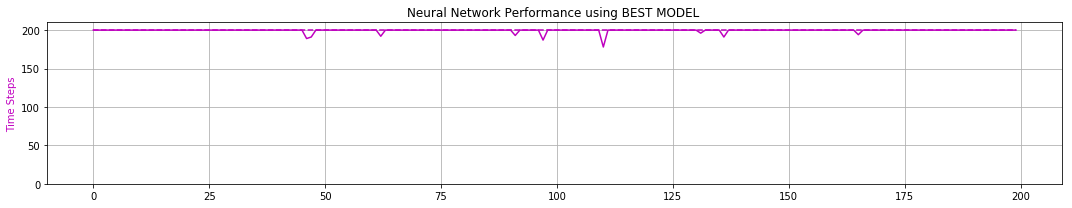

peak memory: 12439.97 MiB, increment: 10796.95 MiB
0 -max- [ 0.198  1.214  0.185  1.872  0.475]
0 -min- [-2.400 -3.217 -0.209 -2.671  0.425]

1 -max- [ 0.191  1.209  0.048  1.800  0.525]
1 -min- [-2.399 -3.312 -0.209 -1.993  0.476]

2 -max- [ 0.188  1.205  0.084  1.881  0.575]
2 -min- [-2.398 -3.405 -0.209 -2.223  0.525]

3 -max- [ 0.184  1.204  0.073  1.714  0.625]
3 -min- [-2.400 -3.199 -0.209 -1.987  0.575]

4 -max- [ 0.203  1.193  0.059  1.722  0.674]
4 -min- [-2.399 -3.168 -0.209 -2.118  0.625]

5 -max- [ 0.192  1.215  0.094  1.934  0.724]
5 -min- [-2.397 -3.202 -0.209 -2.274  0.676]

6 -max- [ 0.225  1.214  0.094  1.948  0.775]
6 -min- [-2.396 -3.176 -0.209 -2.286  0.725]

7 -max- [ 0.187  1.171  0.151  1.994  0.825]
7 -min- [-2.399 -3.193 -0.209 -2.453  0.775]

8 -max- [ 0.206  1.215  0.189  2.026  0.874]
8 -min- [-2.395 -3.164 -0.209 -2.466  0.828]

9 -max- [ 0.184  1.211  0.208  1.974  0.925]
9 -min- [-2.381 -3.177 -0.209 -2.369  0.875]

Quantization TIME:  0.1 minutes


ITERA

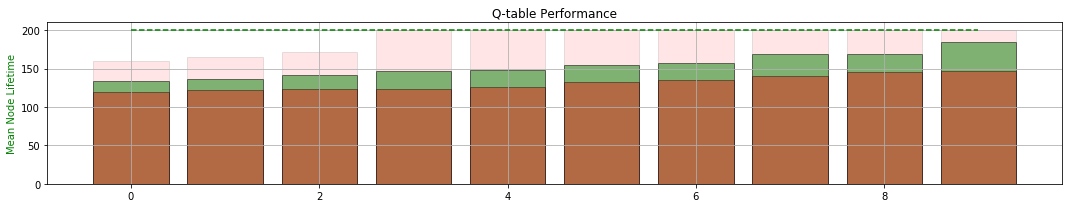

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 78.314	LOSS : 72.797	LOSS : 71.130	LOSS : 69.183	LOSS : 74.197	LOSS : 76.287	LOSS : 74.585	LOSS : 66.705	LOSS : 66.662	LOSS : 61.606	LOSS : 60.929	LOSS : 71.542	LOSS : 72.104	LOSS : 70.986	LOSS : 72.979	LOSS : 63.680	LOSS : 70.748	LOSS : 63.531	LOSS : 72.981	LOSS : 62.562	
Validating... MEAN TIME:  124.175
LOSS : 63.806	LOSS : 62.039	LOSS : 67.403	LOSS : 71.784	LOSS : 70.608	LOSS : 66.920	LOSS : 67.601	LOSS : 63.749	LOSS : 67.070	LOSS : 63.738	LOSS : 64.200	LOSS : 60.629	LOSS : 71.599	LOSS : 63.149	LOSS : 68.685	LOSS : 70.739	LOSS : 54.774	LOSS : 62.290	LOSS : 52.781	LOSS : 61.182	
Validating... MEAN TIME:  142.69
LOSS : 59.488	LOSS : 65.336	LOSS : 64.130	LOSS : 63.271	LOSS : 61.364	LOSS : 68.164	LOSS : 62.505	LOSS : 65.982	LOSS : 70.244	LOSS : 63.392	LOSS : 61.981	LOSS : 59.405	LOSS : 65.310	LOSS : 64.116	LOSS : 63.814	LOSS : 56.435	LOSS : 67.972	LOSS : 64.394	LOSS : 69.886	LOSS : 56.852	
Validat

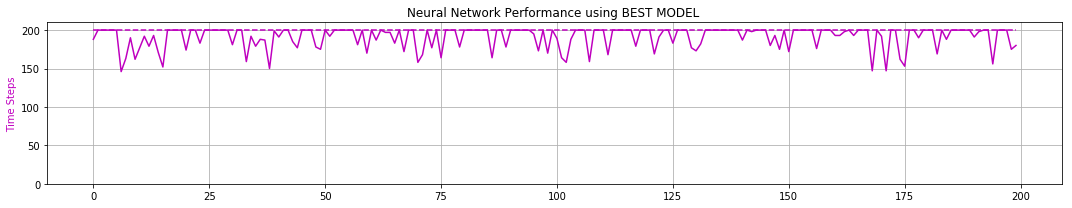

peak memory: 12592.07 MiB, increment: 10902.85 MiB
0 -max- [ 0.150  0.593  0.048  0.688  0.474]
0 -min- [-2.399 -2.788 -0.209 -1.068  0.426]

1 -max- [ 0.138  0.619  0.049  0.725  0.525]
1 -min- [-2.400 -2.716 -0.209 -1.014  0.476]

2 -max- [ 0.136  0.608  0.049  0.846  0.575]
2 -min- [-2.399 -2.596 -0.209 -1.035  0.525]

3 -max- [ 0.204  0.545  0.049  0.911  0.625]
3 -min- [-2.400 -2.599 -0.209 -0.831  0.575]

4 -max- [ 0.150  0.626  0.057  0.863  0.675]
4 -min- [-2.400 -2.582 -0.209 -0.881  0.626]

5 -max- [ 0.205  0.591  0.048  0.700  0.723]
5 -min- [-2.400 -2.574 -0.204 -0.987  0.676]

6 -max- [ 0.122  0.632  0.048  0.867  0.775]
6 -min- [-2.399 -2.536 -0.201 -1.033  0.725]

7 -max- [ 0.177  0.601  0.051  0.926  0.825]
7 -min- [-2.400 -2.406 -0.194 -0.796  0.775]

8 -max- [ 0.130  0.621  0.049  0.931  0.875]
8 -min- [-2.400 -2.593 -0.195 -1.022  0.825]

9 -max- [ 0.181  0.581  0.050  0.833  0.925]
9 -min- [-2.400 -2.393 -0.176 -0.800  0.876]

Quantization TIME:  0.1 minutes


ITERA

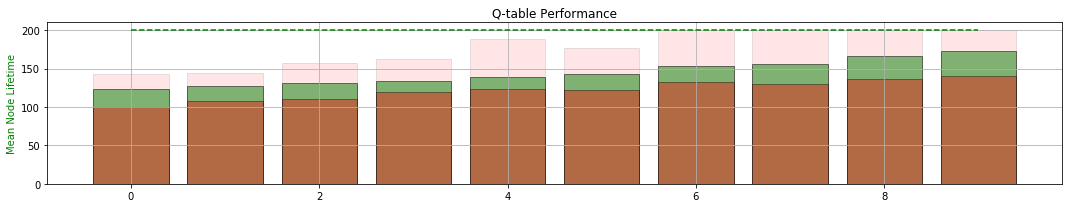

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 47.988	LOSS : 48.310	LOSS : 63.001	LOSS : 57.397	LOSS : 50.111	LOSS : 53.939	LOSS : 52.951	LOSS : 59.108	LOSS : 57.026	LOSS : 50.377	LOSS : 58.549	LOSS : 52.016	LOSS : 49.955	LOSS : 59.689	LOSS : 55.945	LOSS : 56.077	LOSS : 61.775	LOSS : 53.112	LOSS : 61.633	LOSS : 54.471	
Validating... MEAN TIME:  9.385
LOSS : 60.984	LOSS : 54.111	LOSS : 48.755	LOSS : 58.015	LOSS : 54.571	LOSS : 55.420	LOSS : 61.958	LOSS : 55.427	LOSS : 62.039	LOSS : 48.626	LOSS : 53.369	LOSS : 57.154	LOSS : 58.460	LOSS : 59.904	LOSS : 45.713	LOSS : 53.143	LOSS : 55.884	LOSS : 48.122	LOSS : 50.651	LOSS : 49.860	
Validating... MEAN TIME:  70.87
LOSS : 55.666	LOSS : 57.067	LOSS : 51.803	LOSS : 53.932	LOSS : 59.713	LOSS : 57.071	LOSS : 55.127	LOSS : 53.321	LOSS : 50.736	LOSS : 55.718	LOSS : 54.865	LOSS : 54.449	LOSS : 59.383	LOSS : 52.402	LOSS : 48.389	LOSS : 54.059	LOSS : 55.291	LOSS : 55.413	LOSS : 53.516	LOSS : 52.873	
Validating

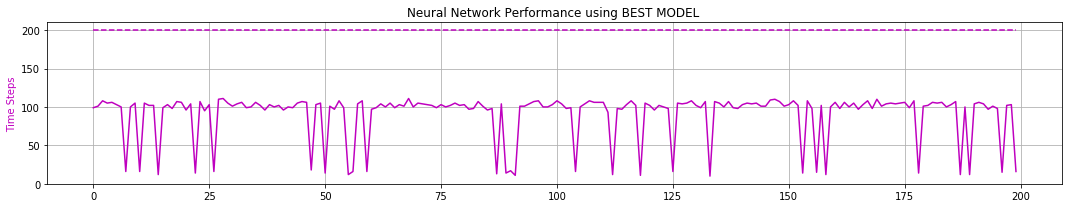

peak memory: 12352.65 MiB, increment: 10695.60 MiB
0 -max- [ 0.156  0.777  0.049  0.724  0.475]
0 -min- [-2.400 -2.965 -0.209 -1.147  0.425]

1 -max- [ 0.136  0.814  0.049  0.715  0.525]
1 -min- [-2.400 -2.980 -0.209 -1.129  0.475]

2 -max- [ 0.160  0.634  0.049  0.700  0.573]
2 -min- [-2.400 -2.950 -0.208 -0.932  0.525]

3 -max- [ 0.144  0.750  0.050  0.862  0.625]
3 -min- [-2.399 -2.942 -0.209 -1.171  0.575]

4 -max- [ 0.169  0.634  0.048  0.716  0.674]
4 -min- [-2.400 -2.951 -0.202 -0.918  0.628]

5 -max- [ 0.120  0.815  0.048  0.970  0.725]
5 -min- [-2.399 -2.775 -0.205 -1.147  0.676]

6 -max- [ 0.150  0.631  0.051  0.944  0.775]
6 -min- [-2.399 -2.757 -0.205 -1.080  0.726]

7 -max- [ 0.104  0.634  0.049  0.943  0.824]
7 -min- [-2.399 -2.781 -0.202 -1.031  0.775]

8 -max- [ 0.118  0.630  0.050  0.951  0.875]
8 -min- [-2.399 -2.772 -0.205 -1.065  0.826]

9 -max- [ 0.149  0.542  0.056  0.965  0.925]
9 -min- [-2.400 -2.745 -0.192 -0.902  0.875]

Quantization TIME:  0.1 minutes


ITERA

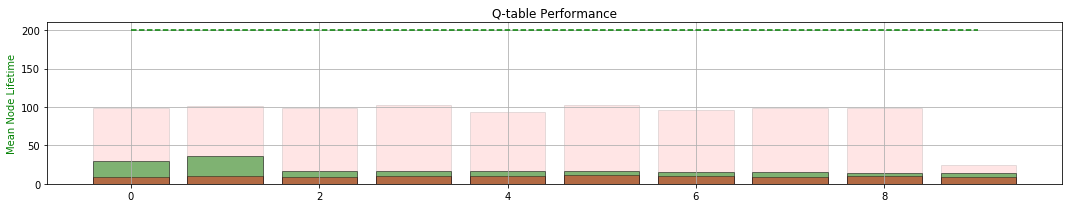

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 95.840	LOSS : 96.159	LOSS : 86.619	LOSS : 96.087	LOSS : 96.968	LOSS : 97.500	LOSS : 97.329	LOSS : 86.959	LOSS : 108.215	LOSS : 89.943	LOSS : 90.907	LOSS : 86.764	LOSS : 94.256	LOSS : 84.944	LOSS : 96.637	LOSS : 88.734	LOSS : 98.599	LOSS : 97.592	LOSS : 96.745	LOSS : 85.374	
Validating... MEAN TIME:  122.09
LOSS : 91.182	LOSS : 93.461	LOSS : 91.891	LOSS : 90.079	LOSS : 96.824	LOSS : 98.128	LOSS : 110.948	LOSS : 99.894	LOSS : 104.235	LOSS : 97.495	LOSS : 98.089	LOSS : 100.318	LOSS : 106.033	LOSS : 106.029	LOSS : 97.949	LOSS : 88.419	LOSS : 98.305	LOSS : 98.471	LOSS : 96.846	LOSS : 95.091	
Validating... MEAN TIME:  109.76
LOSS : 103.566	LOSS : 97.781	LOSS : 98.533	LOSS : 97.746	LOSS : 102.789	LOSS : 93.278	LOSS : 105.274	LOSS : 103.521	LOSS : 88.306	LOSS : 100.695	LOSS : 92.479	LOSS : 98.254	LOSS : 95.466	LOSS : 102.560	LOSS : 96.180	LOSS : 99.198	LOSS : 86.422	LOSS : 96.525	LOSS : 97.673	LOSS : 102.

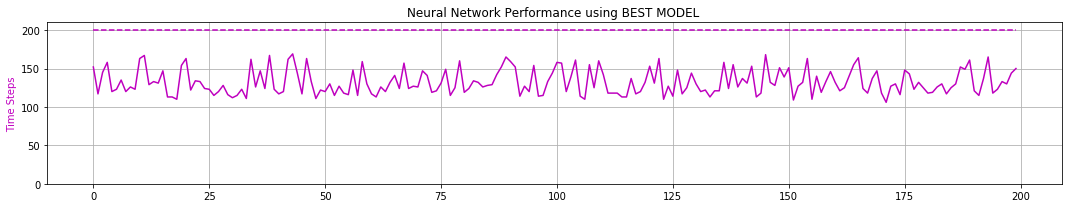

peak memory: 12423.60 MiB, increment: 10766.06 MiB
0 -max- [ 0.201  1.399  0.049  1.654  0.475]
0 -min- [-2.385 -3.211 -0.209 -1.993  0.425]

1 -max- [ 0.218  1.326  0.123  1.911  0.524]
1 -min- [-2.398 -3.328 -0.209 -1.978  0.475]

2 -max- [ 0.207  1.552  0.050  1.572  0.575]
2 -min- [-2.389 -3.153 -0.209 -2.373  0.525]

3 -max- [ 0.219  1.220  0.048  1.424  0.625]
3 -min- [-2.367 -2.926 -0.209 -1.806  0.575]

4 -max- [ 0.201  1.367  0.048  1.329  0.674]
4 -min- [-2.363 -2.974 -0.209 -1.990  0.625]

5 -max- [ 0.216  1.411  0.051  1.744  0.725]
5 -min- [-2.394 -3.211 -0.209 -1.998  0.675]

6 -max- [ 0.201  1.521  0.067  1.358  0.775]
6 -min- [-2.354 -2.826 -0.209 -2.321  0.725]

7 -max- [ 0.208  1.341  0.073  1.324  0.825]
7 -min- [-2.362 -2.821 -0.209 -1.994  0.775]

8 -max- [ 0.222  1.394  0.101  1.593  0.875]
8 -min- [-2.387 -3.002 -0.209 -2.129  0.825]

9 -max- [ 0.206  1.376  0.049  0.358  0.925]
9 -min- [-0.050 -0.790 -0.209 -1.995  0.876]

Quantization TIME:  0.1 minutes


ITERA

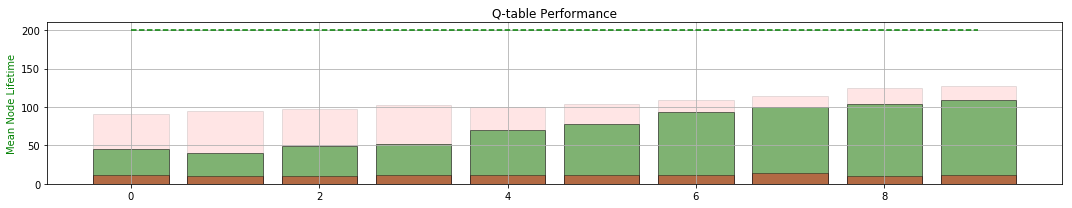

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 124.650	LOSS : 124.747	LOSS : 105.710	LOSS : 116.820	LOSS : 119.349	LOSS : 128.968	LOSS : 119.932	LOSS : 119.153	LOSS : 116.213	LOSS : 129.636	LOSS : 119.231	LOSS : 130.581	LOSS : 126.481	LOSS : 123.455	LOSS : 118.750	LOSS : 123.464	LOSS : 123.543	LOSS : 121.005	LOSS : 127.640	LOSS : 126.400	
Validating... MEAN TIME:  136.155
LOSS : 130.510	LOSS : 121.252	LOSS : 114.804	LOSS : 121.358	LOSS : 128.574	LOSS : 121.817	LOSS : 130.423	LOSS : 120.457	LOSS : 115.155	LOSS : 124.061	LOSS : 128.307	LOSS : 111.948	LOSS : 119.925	LOSS : 126.426	LOSS : 128.443	LOSS : 130.255	LOSS : 124.461	LOSS : 127.055	LOSS : 119.286	LOSS : 115.206	
Validating... MEAN TIME:  98.235
LOSS : 112.518	LOSS : 122.096	LOSS : 118.112	LOSS : 112.685	LOSS : 118.093	LOSS : 110.676	LOSS : 122.629	LOSS : 113.926	LOSS : 120.296	LOSS : 114.727	LOSS : 117.760	LOSS : 115.854	LOSS : 120.880	LOSS : 119.934	LOSS : 110.338	LOSS : 116.975	LOSS : 1

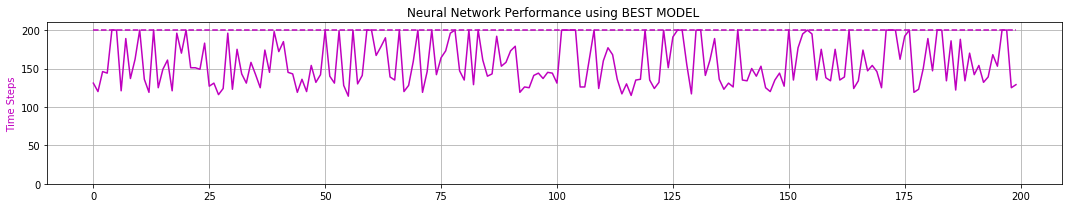

peak memory: 12334.02 MiB, increment: 10677.29 MiB
0 -max- [ 0.216  1.219  0.049  1.010  0.475]
0 -min- [-1.700 -2.167 -0.209 -1.890  0.426]

1 -max- [ 0.205  1.410  0.050  1.005  0.525]
1 -min- [-1.729 -2.195 -0.209 -2.034  0.476]

2 -max- [ 0.211  1.214  0.048  1.018  0.575]
2 -min- [-1.685 -2.144 -0.209 -1.774  0.526]

3 -max- [ 0.183  1.367  0.048  1.001  0.624]
3 -min- [-1.965 -2.212 -0.209 -1.989  0.576]

4 -max- [ 0.209  1.411  0.051  1.219  0.674]
4 -min- [-1.779 -2.054 -0.209 -1.971  0.625]

5 -max- [ 0.192  1.196  0.049  1.229  0.725]
5 -min- [-1.889 -2.057 -0.209 -1.751  0.675]

6 -max- [ 0.191  1.169  0.056  1.452  0.775]
6 -min- [-1.882 -2.074 -0.209 -1.664  0.726]

7 -max- [ 0.196  1.152  0.050  1.250  0.825]
7 -min- [-1.807 -1.866 -0.209 -1.677  0.775]

8 -max- [ 0.186  1.201  0.049  1.324  0.874]
8 -min- [-1.974 -2.037 -0.209 -1.667  0.825]

9 -max- [ 0.163  1.162  0.050  1.175  0.925]
9 -min- [-1.904 -1.870 -0.209 -1.654  0.875]

Quantization TIME:  0.1 minutes


ITERA

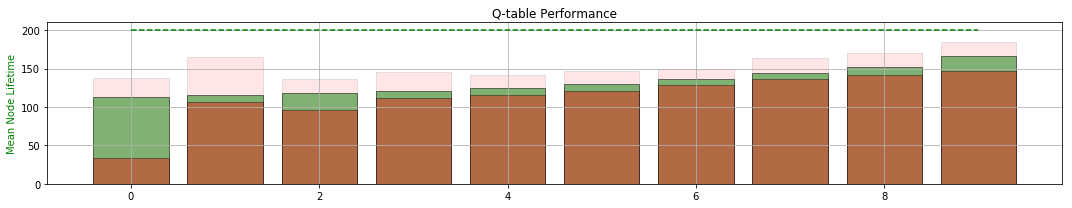

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 90.912	LOSS : 89.372	LOSS : 85.506	LOSS : 81.140	LOSS : 82.452	LOSS : 81.799	LOSS : 73.018	LOSS : 80.116	LOSS : 67.770	LOSS : 79.023	LOSS : 73.453	LOSS : 74.542	LOSS : 80.862	LOSS : 69.618	LOSS : 70.879	LOSS : 72.727	LOSS : 73.854	LOSS : 77.177	LOSS : 76.251	LOSS : 78.371	
Validating... MEAN TIME:  169.895
LOSS : 73.495	LOSS : 79.047	LOSS : 82.841	LOSS : 67.260	LOSS : 69.208	LOSS : 78.860	LOSS : 77.669	LOSS : 74.356	LOSS : 78.225	LOSS : 76.551	LOSS : 75.352	LOSS : 88.936	LOSS : 73.697	LOSS : 76.159	LOSS : 81.378	LOSS : 73.527	LOSS : 74.783	LOSS : 74.076	LOSS : 69.997	LOSS : 76.404	
Validating... MEAN TIME:  157.715
LOSS : 80.331	LOSS : 80.810	LOSS : 72.740	LOSS : 76.028	LOSS : 76.030	LOSS : 80.942	LOSS : 77.828	LOSS : 78.211	LOSS : 80.174	LOSS : 73.782	LOSS : 76.802	LOSS : 74.814	LOSS : 66.327	LOSS : 72.055	LOSS : 74.745	LOSS : 75.169	LOSS : 68.252	LOSS : 70.460	LOSS : 74.555	LOSS : 74.628	
Valida

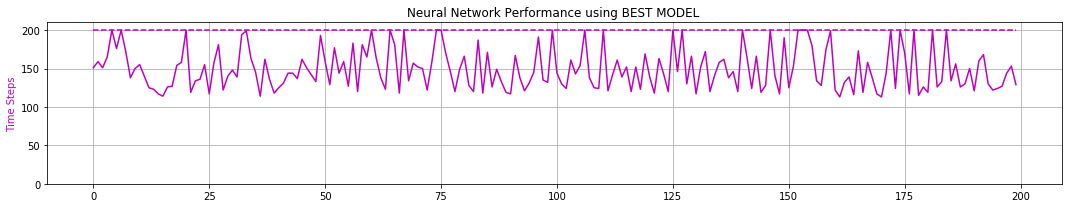

peak memory: 12379.12 MiB, increment: 10706.42 MiB
0 -max- [ 0.156  0.744  0.050  1.540  0.475]
0 -min- [-2.400 -3.554 -0.208 -1.089  0.425]

1 -max- [ 0.208  0.605  0.048  1.565  0.525]
1 -min- [-2.400 -3.480 -0.202 -0.975  0.475]

2 -max- [ 0.141  0.590  0.048  1.536  0.575]
2 -min- [-2.399 -3.487 -0.208 -1.024  0.525]

3 -max- [ 0.169  0.755  0.051  1.317  0.625]
3 -min- [-2.398 -3.161 -0.193 -1.143  0.576]

4 -max- [ 0.149  0.578  0.049  1.323  0.675]
4 -min- [-2.400 -3.146 -0.196 -0.951  0.625]

5 -max- [ 0.143  0.765  0.050  1.311  0.725]
5 -min- [-2.399 -3.000 -0.195 -1.132  0.675]

6 -max- [ 0.158  0.618  0.050  1.490  0.774]
6 -min- [-2.399 -3.114 -0.188 -1.070  0.725]

7 -max- [ 0.139  0.607  0.049  1.312  0.825]
7 -min- [-2.400 -2.830 -0.181 -1.045  0.777]

8 -max- [ 0.133  0.609  0.050  1.229  0.875]
8 -min- [-2.399 -2.635 -0.179 -1.006  0.825]

9 -max- [ 0.135  0.608  0.050  1.198  0.925]
9 -min- [-2.400 -2.463 -0.153 -0.986  0.876]

Quantization TIME:  0.1 minutes


ITERA

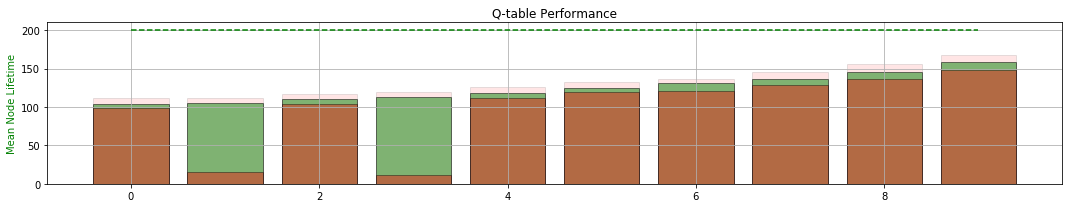

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 55.409	LOSS : 67.430	LOSS : 61.234	LOSS : 60.771	LOSS : 52.073	LOSS : 61.700	LOSS : 56.680	LOSS : 61.706	LOSS : 59.652	LOSS : 57.368	LOSS : 61.956	LOSS : 61.317	LOSS : 57.270	LOSS : 58.324	LOSS : 54.159	LOSS : 53.640	LOSS : 58.273	LOSS : 59.111	LOSS : 62.610	LOSS : 59.496	
Validating... MEAN TIME:  181.2
LOSS : 56.559	LOSS : 60.033	LOSS : 59.665	LOSS : 57.710	LOSS : 57.682	LOSS : 64.086	LOSS : 66.199	LOSS : 60.555	LOSS : 62.163	LOSS : 58.597	LOSS : 59.062	LOSS : 58.985	LOSS : 58.353	LOSS : 60.795	LOSS : 56.687	LOSS : 58.271	LOSS : 63.376	LOSS : 52.388	LOSS : 64.554	LOSS : 62.675	
Validating... MEAN TIME:  111.955
LOSS : 65.520	LOSS : 48.730	LOSS : 56.350	LOSS : 58.580	LOSS : 59.707	LOSS : 56.670	LOSS : 56.022	LOSS : 61.687	LOSS : 62.910	LOSS : 66.082	LOSS : 60.770	LOSS : 59.081	LOSS : 60.812	LOSS : 62.030	LOSS : 59.925	LOSS : 55.977	LOSS : 61.007	LOSS : 63.486	LOSS : 61.026	LOSS : 69.516	
Validati

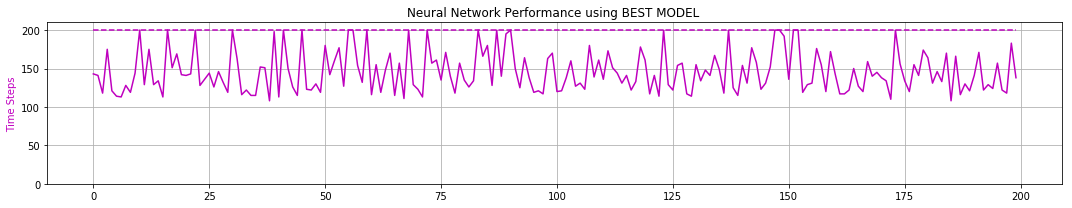

peak memory: 12410.10 MiB, increment: 10706.68 MiB
0 -max- [ 0.193  1.024  0.048  1.005  0.475]
0 -min- [-2.399 -3.269 -0.208 -1.486  0.425]

1 -max- [ 0.179  1.176  0.048  1.182  0.524]
1 -min- [-2.400 -3.182 -0.202 -1.755  0.475]

2 -max- [ 0.182  1.020  0.057  1.228  0.574]
2 -min- [-2.400 -3.316 -0.197 -1.431  0.526]

3 -max- [ 0.160  1.219  0.049  0.979  0.625]
3 -min- [-2.398 -2.949 -0.203 -1.747  0.575]

4 -max- [ 0.161  1.180  0.050  1.028  0.675]
4 -min- [-2.399 -2.947 -0.207 -1.738  0.626]

5 -max- [ 0.180  0.981  0.054  0.945  0.725]
5 -min- [-2.399 -2.722 -0.171 -1.422  0.675]

6 -max- [ 0.160  0.829  0.049  0.965  0.774]
6 -min- [-2.400 -2.766 -0.165 -1.201  0.725]

7 -max- [ 0.144  1.007  0.050  0.939  0.824]
7 -min- [-2.399 -2.418 -0.178 -1.447  0.775]

8 -max- [ 0.146  0.821  0.050  0.857  0.874]
8 -min- [-2.400 -2.259 -0.140 -1.187  0.826]

9 -max- [ 0.131  0.826  0.050  0.667  0.925]
9 -min- [-2.400 -2.207 -0.140 -1.165  0.875]

Quantization TIME:  0.1 minutes


ITERA

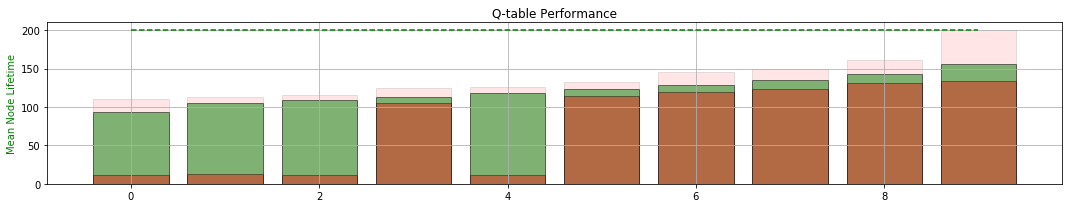

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 67.860	LOSS : 77.521	LOSS : 74.867	LOSS : 74.283	LOSS : 72.359	LOSS : 64.978	LOSS : 70.485	LOSS : 67.663	LOSS : 65.720	LOSS : 70.549	LOSS : 64.146	LOSS : 70.393	LOSS : 73.666	LOSS : 70.203	LOSS : 69.291	LOSS : 67.042	LOSS : 60.352	LOSS : 59.744	LOSS : 67.746	LOSS : 72.067	
Validating... MEAN TIME:  200.0
LOSS : 71.379	LOSS : 63.054	LOSS : 65.380	LOSS : 72.558	LOSS : 71.093	LOSS : 69.398	LOSS : 69.721	LOSS : 73.912	LOSS : 74.707	LOSS : 71.221	LOSS : 70.933	LOSS : 63.278	LOSS : 64.838	LOSS : 67.622	LOSS : 64.103	LOSS : 67.604	LOSS : 60.696	LOSS : 66.568	LOSS : 70.235	LOSS : 67.426	
Validating... MEAN TIME:  108.435
LOSS : 64.345	LOSS : 70.663	LOSS : 76.034	LOSS : 68.419	LOSS : 77.428	LOSS : 72.306	LOSS : 67.735	LOSS : 61.923	LOSS : 66.060	LOSS : 62.783	LOSS : 67.684	LOSS : 68.100	LOSS : 65.399	LOSS : 62.160	LOSS : 68.462	LOSS : 64.288	LOSS : 68.115	LOSS : 68.173	LOSS : 65.831	LOSS : 67.979	
Validati

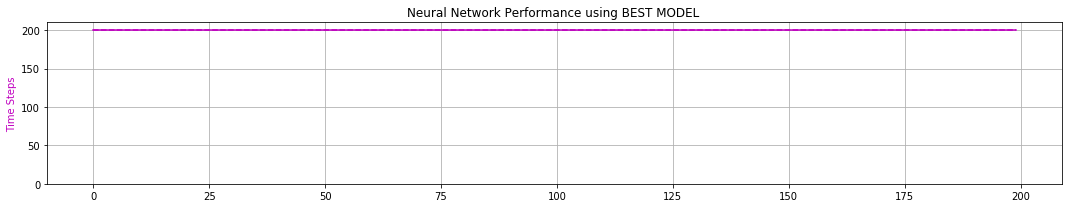

peak memory: 12623.36 MiB, increment: 10920.49 MiB
0 -max- [ 0.194  1.367  0.048  1.021  0.475]
0 -min- [-2.399 -3.157 -0.209 -1.990  0.425]

1 -max- [ 0.202  1.210  0.051  1.114  0.524]
1 -min- [-2.400 -3.108 -0.209 -1.767  0.476]

2 -max- [ 0.172  1.218  0.049  1.024  0.574]
2 -min- [-2.399 -3.000 -0.203 -1.757  0.525]

3 -max- [ 0.180  1.215  0.050  0.964  0.624]
3 -min- [-2.400 -2.924 -0.199 -1.769  0.576]

4 -max- [ 0.192  1.373  0.050  0.920  0.675]
4 -min- [-2.400 -2.771 -0.197 -1.990  0.626]

5 -max- [ 0.152  1.196  0.049  0.995  0.725]
5 -min- [-2.398 -2.637 -0.209 -1.744  0.675]

6 -max- [ 0.144  0.966  0.050  0.996  0.772]
6 -min- [-2.400 -2.612 -0.208 -1.477  0.726]

7 -max- [ 0.153  1.022  0.061  1.008  0.825]
7 -min- [-2.400 -2.402 -0.170 -1.444  0.775]

8 -max- [ 0.152  0.981  0.050  0.911  0.874]
8 -min- [-2.399 -2.362 -0.178 -1.395  0.825]

9 -max- [ 0.147  0.948  0.060  0.958  0.924]
9 -min- [-2.400 -1.989 -0.177 -1.383  0.875]

Quantization TIME:  0.1 minutes


ITERA

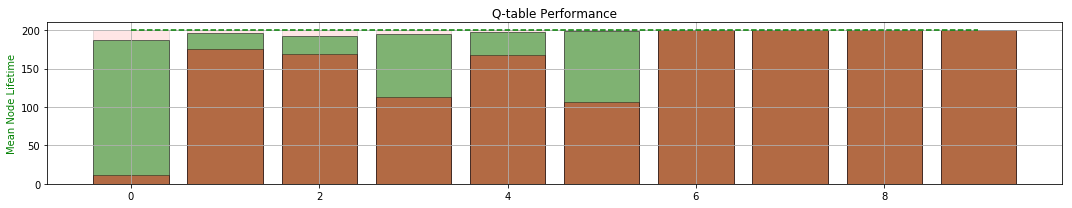

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)

            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  2741.0
Total Serial Timesteps   :  1933011.0
Speed-up                 :  705.22


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

  9295 SUCCESS  12  15    2741    1933011     705.22
